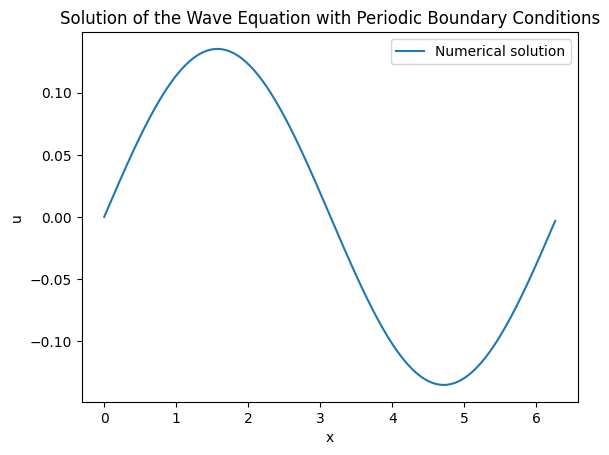

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# Parameters
L = 2 * np.pi  # Domain length
N = 256        # Number of grid points
dx = L / N     # Grid spacing
c = 1.0        # Wave speed
dt = 0.01      # Time step
T = 2.0        # Final time

# Create the grid
x = np.linspace(0, L, N, endpoint=False)

# Initial condition: u(x,0) = sin(x)
u = np.sin(x)

# Fourier modes
k = np.fft.fftfreq(N, d=dx) * 2 * np.pi

# Time-stepping loop
t = 0
while t < T:
    u_hat = fft(u)
    u_hat_new = u_hat * np.exp(-c * (k**2) * dt)
    u = np.real(ifft(u_hat_new))
    t += dt

# Plot the final result
plt.plot(x, u, label='Numerical solution')
plt.xlabel('x')
plt.ylabel('u')
plt.title('Solution of the Wave Equation with Periodic Boundary Conditions')
plt.legend()
plt.show()


In [2]:
!pip install fenics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 9.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.7/282.7 kB 10.0 MB/s eta 0:00:00


In [ ]:
from fenics import *

# Create mesh and define function space
mesh = UnitSquareMesh(32, 32)
V = FunctionSpace(mesh, "CG", 1, constrained_domain=PeriodicBoundary())

# Define boundary condition
u0 = Constant(0.0)
dbc = DirichletBoundary()
bc = DirichletBC(V, u0, dbc)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Expression('sin(5*x[1])', degree=1)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution
import matplotlib.pyplot as plt
plot(u)
plt.show()


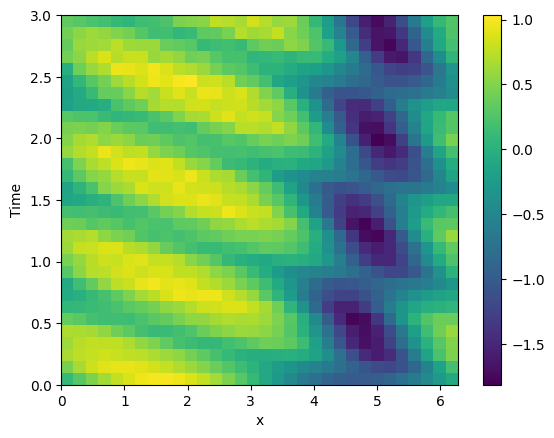

In [4]:
from math import pi

from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph

# initialize the equation and the space
eq = PDE({"φ": "6 * φ * d_dx(φ) - laplace(d_dx(φ))"})
grid = CartesianGrid([[0, 2 * pi]], [32], periodic=True)
state = ScalarField.from_expression(grid, "sin(x)")

# solve the equation and store the trajectory
storage = MemoryStorage()
eq.solve(state, t_range=3, solver="scipy", tracker=storage.tracker(0.1))

# plot the trajectory as a space-time plot
plot_kymograph(storage)

1. u를 periodic boundary를 사용해서 시뮬레이션
2. periodic boundary구현
3. u랑 v를 업데이트

1. u에 대한 정보를 위치에 대해서 업데이트 한다

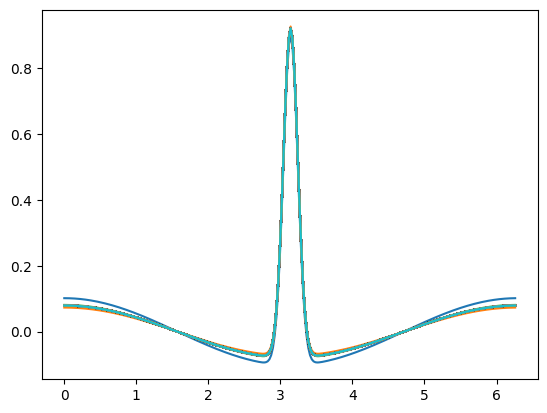

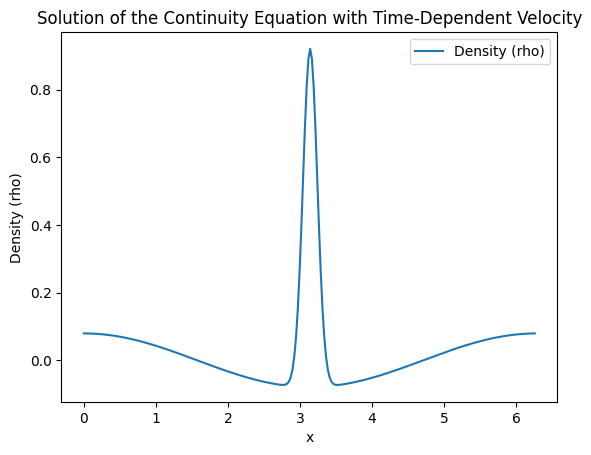

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# Parameters
L = 2 * np.pi  # Domain length
N = 256        # Number of grid points
dx = L / N     # Grid spacing
dt = 0.01      # Time step
T = 2.0        # Total time

# Create the grid
x = np.linspace(0, L, N, endpoint=False)

# Initial condition: Gaussian distribution for density
rho = np.exp(-0.5 * ((x - np.pi) / 0.1)**2)

# Initial condition: Velocity field (time-dependent example: u = sin(x) * cos(t))
u = np.sin(x) * np.cos(0)

# Fourier modes
k = np.fft.fftfreq(N, d=dx) * 2 * np.pi

# Time-stepping loop
t = 0
while t < T:
    rho_hat = fft(rho)
    u = np.sin(x) * np.cos(t)  # Update the velocity field for the current time step
    u_hat = fft(u)
    
    # Compute the derivative of u_hat with respect to x (in Fourier space, multiply by 1j * k)
    u_hat_derivative = 1j * k * u_hat
    
    # Update the Fourier coefficients for rho
    rho_hat = rho_hat - dt * (u_hat_derivative * rho_hat)
    rho = np.real(ifft(rho_hat))
    plt.plot(x,rho)
    # Update time
    t += dt

# Plot the final result
plt.figure()
plt.plot(x, rho, label='Density (rho)')
plt.xlabel('x')
plt.ylabel('Density (rho)')
plt.title('Solution of the Continuity Equation with Time-Dependent Velocity')
plt.legend()
plt.show()


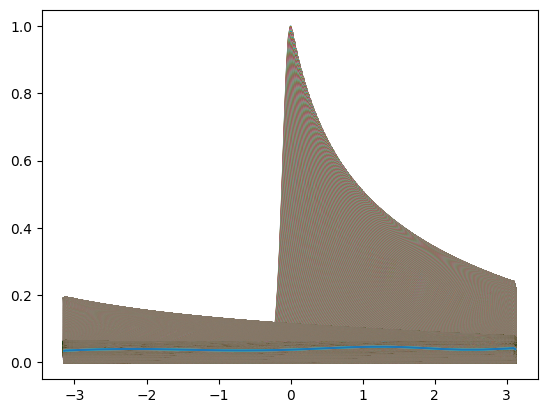

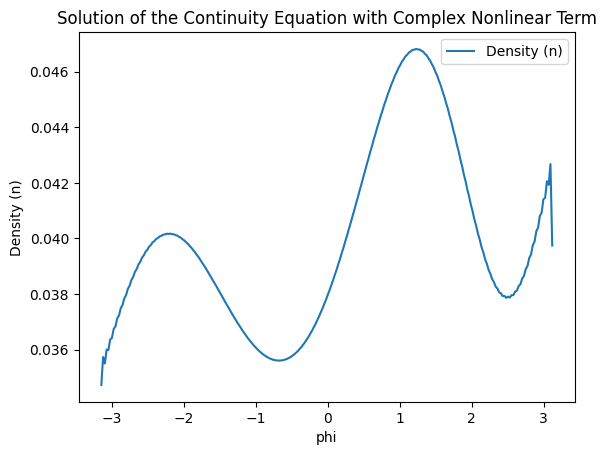

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# Parameters
L = 2 * np.pi  # Domain length
N = 256        # Number of grid points
dx = L / N     # Grid spacing
dt = 0.001      # Time step
T = 50.0        # Total time
omega = 1.0    # Example parameter
b = 0.1        # Example parameter
nu = 0.5       # Example parameter
diffusivity = 0.01  # Diffusion coefficient

# Create the grid
phi = np.linspace(-np.pi, np.pi, N, endpoint=False)

# Initial condition: Example Gaussian distribution
n = np.exp(-0.5 * ((phi) / 0.1)**2)

# Fourier modes
k = np.fft.fftfreq(N, d=dx) * 2 * np.pi

# Time-stepping loop
t = 0
while t < T:
    n_hat = fft(n)
    
    # Compute the nonlinear integral term
    integral_term = np.zeros_like(n)
    for i in range(N):
        phi_prime = phi[i]
        integral_term[i] = np.sum(np.sin(phi - phi_prime) * n) * dx
    
    # Update the Fourier coefficients for the nonlinear term
    nonlinear_term = (omega - b * np.sin(nu * phi) - integral_term) * n
    nonlinear_term_hat = fft(nonlinear_term)
    
    # Update the Fourier coefficients for n using the PDE
    n_hat_new = n_hat - 1j * k * nonlinear_term_hat * dt - diffusivity * (k**2) * n_hat * dt
    
    # Transform back to spatial domain
    n = np.real(ifft(n_hat_new))
    plt.plot(phi,n)
    # Update time
    t += dt

# Plot the final result
plt.figure()
plt.plot(phi, n, label='Density (n)')
plt.xlabel('phi')
plt.ylabel('Density (n)')
plt.title('Solution of the Continuity Equation with Complex Nonlinear Term')
plt.legend()
plt.show()


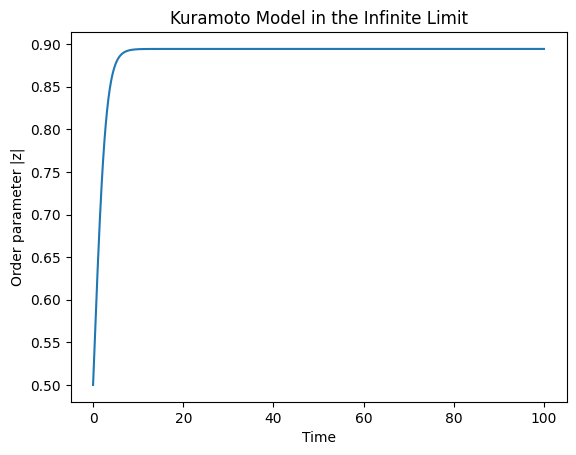

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
K = 1.0    # Coupling constant
omega0 = 1.0   # Natural frequency mean
sigma = 0.1  # Natural frequency standard deviation

# Initial condition for the order parameter z
r0 = 0.5
psi0 = 0.0
z0 = r0 * np.exp(1j * psi0)
z0_real = np.real(z0)
z0_imag = np.imag(z0)

# Ott-Antonsen equations
def ott_antonsen(z, t, K, omega0, sigma):
    z_real, z_imag = z
    z_complex = z_real + 1j * z_imag
    r = np.abs(z_complex)
    psi = np.angle(z_complex)
    dpsi_dt = omega0 + (K / 2) * r * np.sin(-psi)
    dr_dt = -sigma * r + (K / 2) * r * (1 - r**2)
    dz_dt = (dr_dt + 1j * dpsi_dt) * np.exp(1j * psi)
    return [np.real(dz_dt), np.imag(dz_dt)]

# Time array
t = np.linspace(0, 100, 1000)

# Integrate the Ott-Antonsen equations
z = odeint(ott_antonsen, [z0_real, z0_imag], t, args=(K, omega0, sigma))

# Extract the order parameter
z_complex = z[:, 0] + 1j * z[:, 1]
r = np.abs(z_complex)

# Plot the results
plt.figure()
plt.plot(t, r)
plt.xlabel('Time')
plt.ylabel('Order parameter |z|')
plt.title('Kuramoto Model in the Infinite Limit')
plt.show()


# 1. OA ansatz를 대칭과 반대칭으로 구성
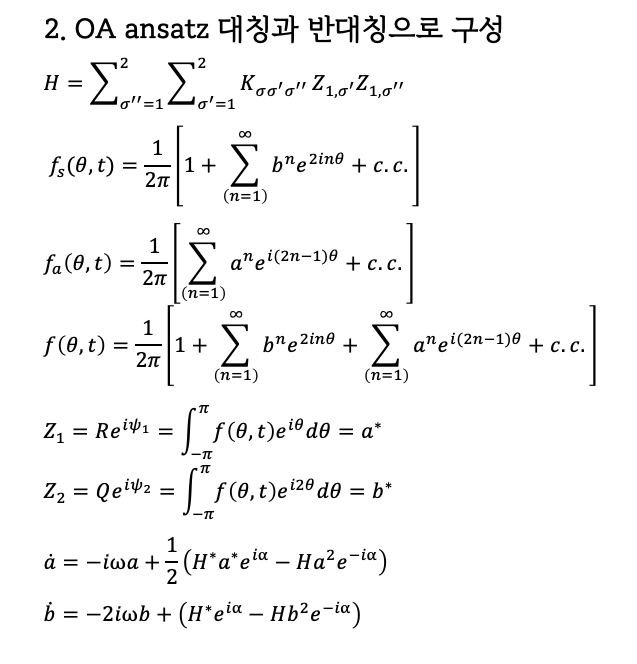

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [104]:
def get_ZE12(Etheta):
    ''' get theta and return r and theta'''
    E1 = Etheta
    E2 = E1**2
    Z1,Z2 = np.mean(E1),np.mean(E2)
    return Z1,Z2
# @jit(nopython=True)
# def Kuramoto_MF_CHIMERA(Theta,t,N,omega,K2,EA):
#     # print("Case m = 0")
#     ET = np.exp(1j*Theta)
#     Z1,Z2 =  get_ZE12(ET)
#     # EA = np.exp(-1j*alpha)
#     ET = np.conjugate(ET)
#     # dtheta  = omega + K2*r*r*np.sin(2*(psi-theta)-alpha) -K2*r/N*np.sin((psi-theta)-alpha) - K2*r/N*np.sin((psi-theta)-alpha) - K2*r2/N*np.sin(psi2-2*theta-alpha)
#     dtheta  = omega + (((K2*EA*(Z1**2-Z2/N))*ET - (2*K2*Z1*EA/N))*ET+2*K2*EA/N/N).imag
#     # dtheta  = omega + K2*((r*r*np.exp(1j*(2*psi-alpha)) - r2/N*np.exp(1j*(psi2-alpha))*np.exp(-1j*theta) - r/N*np.sin((psi-theta)-alpha))*np.exp(-1j*theta)).imag
#     return dtheta


# @jit(nopython=True)
def Kuramoto_MF_CHIMERA(Theta,t,N,omega,K2,alpha):
    # print("Case m = 0")
    ET = np.exp(1j*Theta)
    Z1,Z2 =  get_ZE12(ET)
    A = np.exp(-1j*alpha)
    ET = np.conjugate(ET)
    # dtheta  = omega + K2*r*r*np.sin(2*(psi-theta)-alpha) -K2*r/N*np.sin((psi-theta)-alpha) - K2*r/N*np.sin((psi-theta)-alpha) - K2*r2/N*np.sin(psi2-2*theta-alpha)
    dtheta  = omega + (((K2*A*(Z1**2-Z2/N))*ET - (2*K2*Z1*A/N))*ET+2*K2*A/N/N).imag
    # dtheta  = omega + K2*((r*r*np.exp(1j*(2*psi-alpha)) - r2/N*np.exp(1j*(psi2-alpha))*np.exp(-1j*theta) - r/N*np.sin((psi-theta)-alpha))*np.exp(-1j*theta)).imag
    return dtheta

In [166]:
@jit(nopython=True)
def RK4_ZZ(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    Etheta = np.exp(1j*y0)
    Na = args[0]
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    Z1as = np.zeros(n,dtype=np.complex64)
    Z1bs = np.zeros(n,dtype=np.complex64)
    Z2as = np.zeros(n,dtype=np.complex64)
    Z2bs = np.zeros(n,dtype=np.complex64)

    Z1as[0] = Z1a
    Z2as[0] = Z2a
    Z1bs[0] = Z1b
    Z2bs[0] = Z2b
    
    y[0] = y0
    
    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1,Z1a,Z1b,Z2a,Z2b = f(y[i], t[i], *args)
        k2,_,_,_,_ = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_,_,_,_ = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_,_,_,_ = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        Z1as[i+1],Z1bs[i+1],Z2as[i+1],Z2bs[i+1] = Z1a,Z1b,Z2a,Z2b
    return y,(Z1as,Z1bs,Z2as,Z2bs)
@jit(nopython=True)
def get_ZE12(Etheta):
    ''' get theta and return r and theta'''
    E1 = Etheta
    E2 = E1**2
    Z1,Z2 = np.mean(E1),np.mean(E2)
    return Z1,Z2

# @jit(nopython=True)
# def Kuramoto_MF_CHIMERA(Theta,t,Na,Nb,beta,alpha,K):
#     dtheta = np.zeros(Na+Nb)

#     Etheta = np.exp(1j*Theta)
#     EA,EB = Etheta[:Na],Etheta[Na:]
#     Z1a,Z2a = get_ZE12(EA)
#     Z1b,Z2b = get_ZE12(EB)
#     A = np.exp(-1j*alpha)
#     EA,EB = np.conjugate(EA), np.conjugate(EB)
#     ZZa =  (Z1a+beta*Z1b)
#     ZZb =  (Z1b+beta*Z1a)
#     dtheta[:Na] = K*((A*(ZZa**2-Z2a/Na - beta*Z2b/Nb))*EA*EA -(2*A/Na*ZZa)*EA).imag
#     dtheta[Na:] = K*((A*(ZZb**2-Z2b/Nb - beta*Z2a/Na))*EB*EB -(2*A/Nb*ZZb)*EB).imag
#     return dtheta,Z1a,Z1b,Z2a,Z2b

@jit(nopython=True)
def Kuramoto_MF_CHIMERA(Theta,t,Na,Nb,beta,alpha,K):
    dtheta = np.zeros(Na+Nb)

    Etheta = np.exp(1j*Theta)
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    A = np.exp(-1j*alpha)
    EA,EB = np.conjugate(EA), np.conjugate(EB)
    ZZa =  K*(Z1a+beta*Z1b)
    ZZb =  K*(Z1b+beta*Z1a)
    dtheta[:Na] = ((A*(ZZa**2))*EA*EA).imag
    dtheta[Na:] = ((A*(ZZb**2))*EB*EB).imag
    return dtheta,Z1a,Z1b,Z2a,Z2b

In [135]:
@jit(nopython=True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)),dtype=np.complex128)
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y
@jit(nopython=True)
def OA_ansatz_SAS(Zs,t,beta,alpha,omega):
    a1,b1,a2,b2 = Zs.copy()
    H1 = a1**2 + beta*a1*a2 + beta**2*a2**2
    H2 = a2**2 + beta*a1*a2 + beta**2*a1**2
    CH1 = np.conj(H1)
    CH2 = np.conj(H2)
    Ca1,Ca2 = np.conj(a1),np.conj(a2)
    EA,CEA = np.exp(1j*alpha), np.exp(-1j*alpha)
    da1 = -1j*omega*a1 + 1/2 * (CH1*Ca1*EA-H1*a1**2*CEA)
    da2 = -1j*omega*a2 + 1/2 * (CH2*Ca2*EA-H2*a2**2*CEA)
    db1 = -2j*omega*b1 + CH1*EA - H1*b1**2*CEA
    db2 = -2j*omega*b2 + CH2*EA - H2*b2**2*CEA
    return np.array([da1,db1,da2,db2])


@jit(nopython=True)
def OA_ansatz_SAS(Zs,t,beta,alpha,omega):
    a1,b1,a2,b2 = Zs.copy()
    H1 = a1**2 + beta*a1*a2 + beta**2*a2**2
    H2 = a2**2 + beta*a1*a2 + beta**2*a1**2
    CH1 = np.conj(H1)
    CH2 = np.conj(H2)
    Ca1,Ca2 = np.conj(a1),np.conj(a2)
    EA,CEA = np.exp(1j*alpha), np.exp(-1j*alpha)
    da1 = -1j*omega*a1 + 1/2 * (CH1*Ca1*EA-H1*a1**2*CEA)
    da2 = -1j*omega*a2 + 1/2 * (CH2*Ca2*EA-H2*a2**2*CEA)
    db1 = -2j*omega*b1 + CH1*EA - H1*b1**2*CEA
    db2 = -2j*omega*b2 + CH2*EA - H2*b2**2*CEA
    return np.array([da1,db1,da2,db2])

In [183]:
Z1a.conjugate()

(0.015750527621370157+0.037883084245809856j)

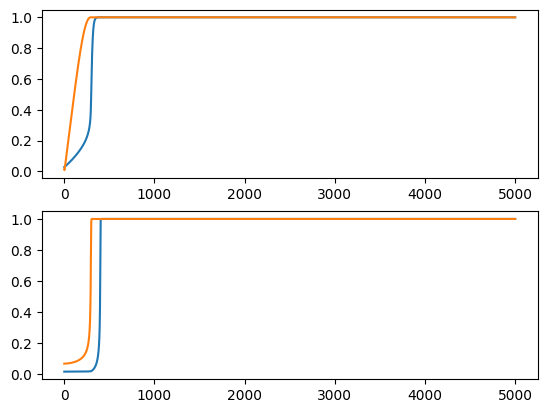

In [203]:
Na = 500
Theta = np.random.uniform(0,2*np.pi,Na*2)

Etheta = np.exp(1j*Theta)
EA,EB = Etheta[:Na],Etheta[Na:]
Z1a,Z2a = get_ZE12(EA)
Z1b,Z2b = get_ZE12(EB)
a1,b1 = Z1a.conjugate(),Z2a.conjugate()
a2,b2 = Z1b.conjugate(),Z2b.conjugate()
Zs = np.array([a1,b1,a2,b2],dtype=np.complex64)
t = np.arange(0,5000,0.01)
beta = 0.2
alpha = 0.8
OR1,OQ1,OR2,OQ2 = np.abs(RK4(OA_ansatz_SAS,Zs,t,args=(beta,alpha,0)).T)

plt.subplot(211)
plt.plot(t,OQ1)
plt.plot(t,OQ2)
plt.subplot(212)
plt.plot(t,OR1)
plt.plot(t,OR2)

In [204]:
N1,N2 = Na,Na
K = 1
_,(Z1as,Z1bs,Z2as,Z2bs) = RK4_ZZ(Kuramoto_MF_CHIMERA,Theta,t,args=(N1,N2,beta,alpha,K))
R1 = np.abs(Z1as)
R2 = np.abs(Z1bs)
Q1 = np.abs(Z2as)
Q2 = np.abs(Z2bs)

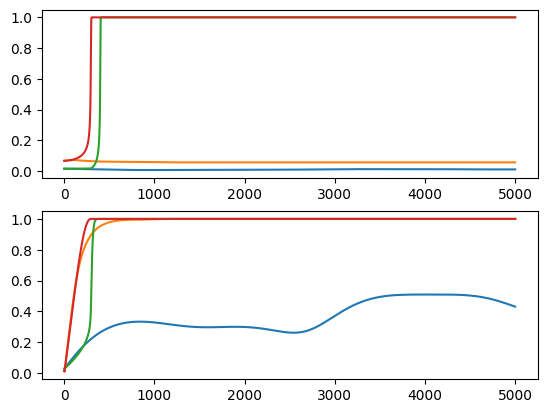

In [205]:
plt.subplot(211)
plt.plot(t,R1)
plt.plot(t,R2)

plt.plot(t,OR1)
plt.plot(t,OR2)

plt.subplot(212)

plt.plot(t,Q1)
plt.plot(t,Q2)

plt.plot(t,OQ1)
plt.plot(t,OQ2)

